In [ ]:
from pathlib import Path
import sys


import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time
import logging
import tifffile
from colokroll.core.format_converter import FormatConverter
from colokroll.data_processing import ImageLoader
from colokroll.imaging_preprocessing.background_subtraction.background_subtractor import BackgroundSubtractor
from colokroll.analysis.cell_segmentation import CellSegmenter
from colokroll.analysis.colocalization import compute_colocalization, export_colocalization_json


# Setup logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

/users/PAS2598/duarte63/GitHub/perinuclear_analysis/perinuclear_analysis/__init__.py:41: UserWarning: MIPPreprocessor not available yet
  warnings.warn("MIPPreprocessor not available yet")
/users/PAS2598/duarte63/GitHub/perinuclear_analysis/perinuclear_analysis/__init__.py:61: UserWarning: Phase 4 dependencies not installed: No module named 'perinuclear_analysis.ring_analysis'
Install with: pip install .[phase4]
  warnings.warn(
/users/PAS2598/duarte63/GitHub/perinuclear_analysis/perinuclear_analysis/__init__.py:74: UserWarning: Phase 5 dependencies not installed: No module named 'perinuclear_analysis.signal_quantification'
Install with: pip install .[phase5]
  warnings.warn(


In [2]:
image_path = Path("/fs/scratch/PAS2598/duarte63/ALIX_confocal_data/ALIX/nd2/x.ome.tiff")
image_loader = ImageLoader()

loaded_data = image_loader.load_image(image_path)
image_loader.get_pixel_size()
loaded_data.dtype

# Rename Channels -> Index (If you don't know what's the order; after image_loader.load_image you can image_loader.get_channel_names()
# and it will show you the actual names in order

new_channel_names = ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']
channel_names = image_loader.rename_channels(new_channel_names)

channel_names = image_loader.get_channel_names()

INFO: Loaded metadata from converted TIFF: pixel_size=0.108333333333333μm
INFO: Squeezed singleton dim(s): (30, 1800, 1800, 4, 1) -> (30, 1800, 1800, 4)
INFO: Successfully loaded TIFF image with shape: (30, 1800, 1800, 4)
INFO: Renamed channels to: ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']


In [3]:
bg_subtractor = BackgroundSubtractor()

results = {}

for i, ch in enumerate(channel_names):
    ch_data = loaded_data[:, :, :, i]
    t0 = time.perf_counter()
    corrected, meta = bg_subtractor.subtract_background(
        image=ch_data,
        channel_name=ch,
        # method omitted -> auto search + full run
    )
    cp.cuda.Stream.null.synchronize()
    dt = time.perf_counter() - t0

    results[ch] = (corrected, meta)

INFO: Initializing CUDA-accelerated background subtractor (CUDA required)
INFO: GPU Memory: 39.0GB free / 39.4GB total
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=50)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=55)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=60)
INFO: Processing 30 z-slices with CUDA rolling ball approximation (radius=50)
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=10
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=12
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=14
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=16
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=10
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=100)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=110)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radiu

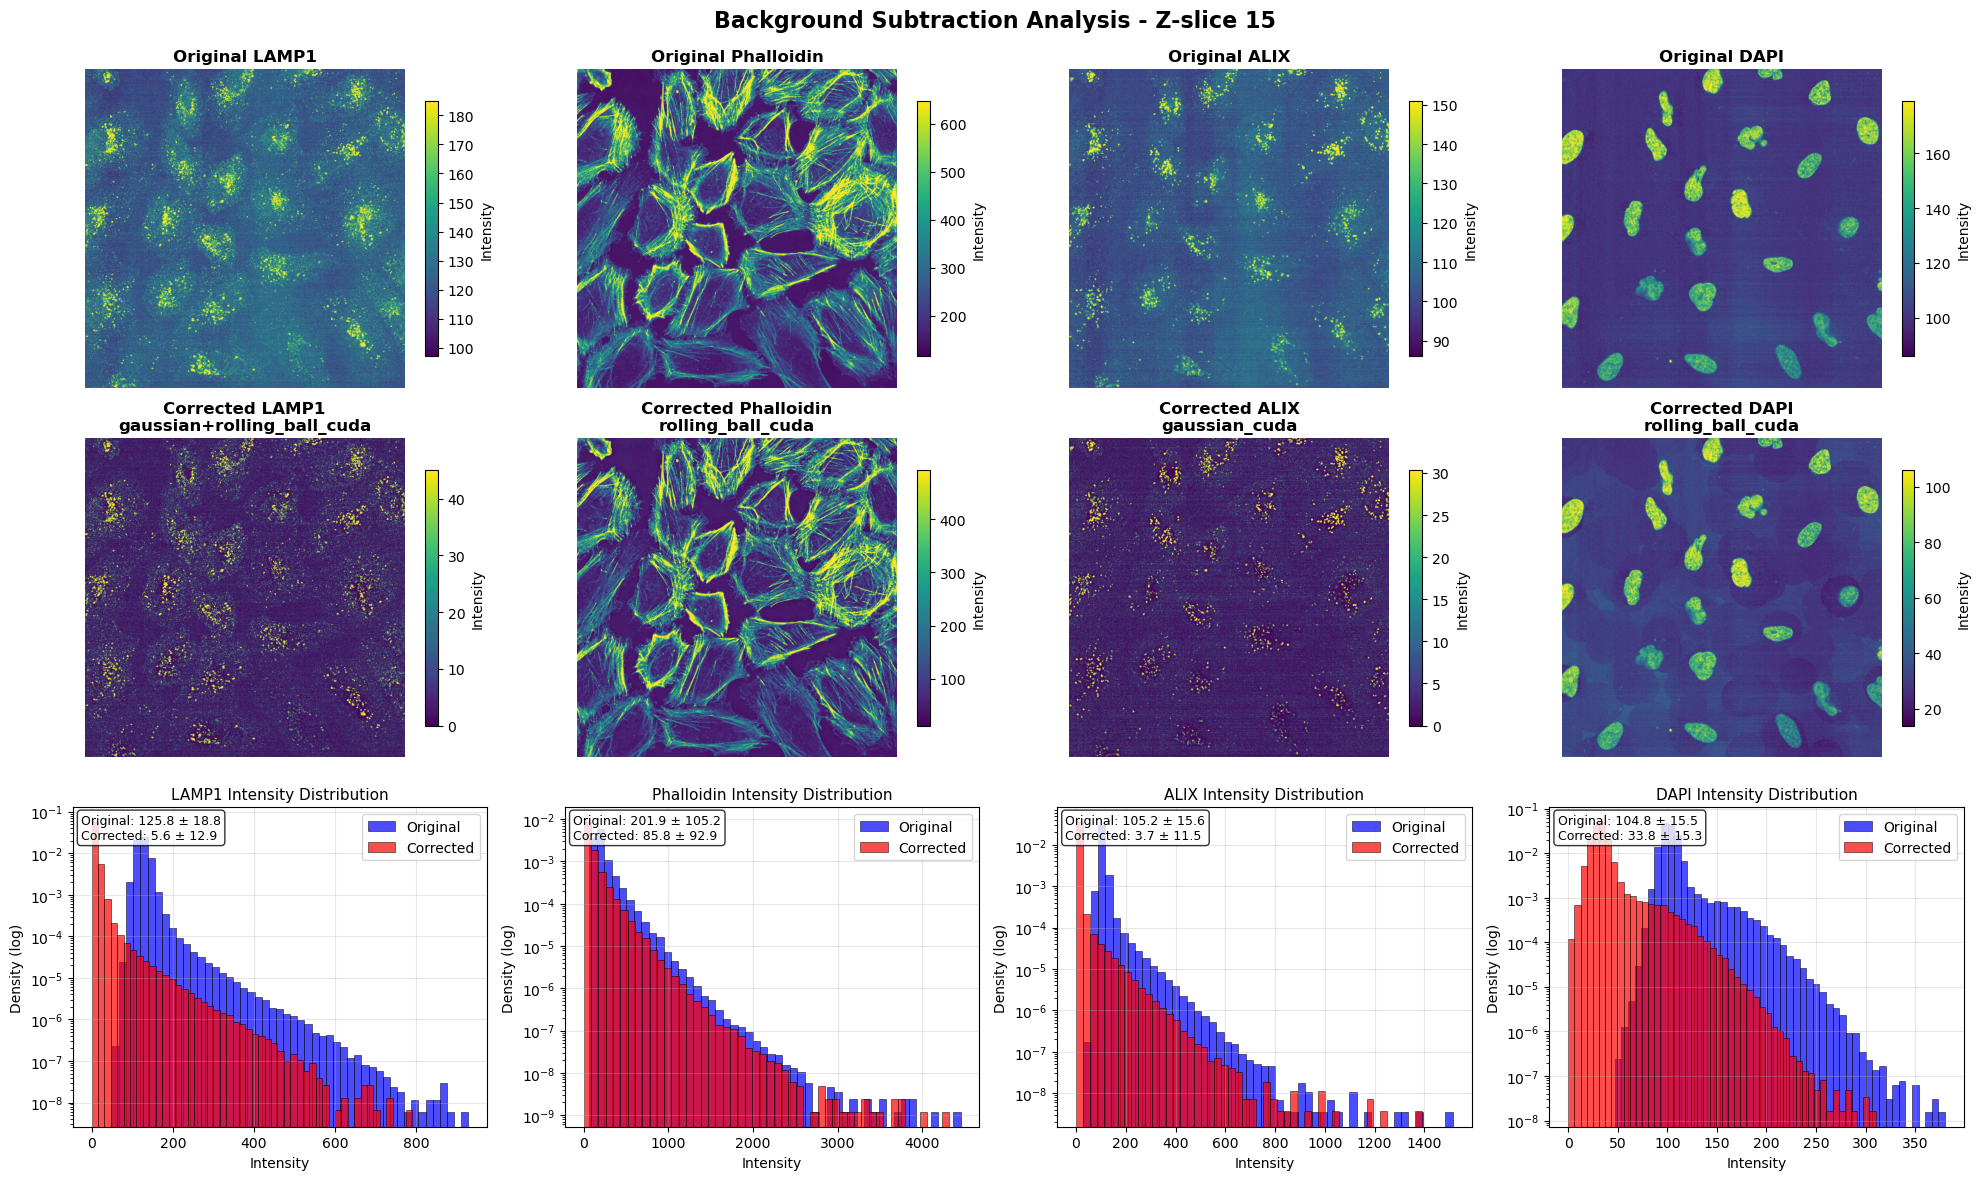

In [4]:
middle_slice_idx = loaded_data.shape[0]//2


fig = bg_subtractor.plot_background_subtraction_comparison(
    original_data=loaded_data,
    corrected_results=results,
    channel_names=channel_names,
    z_slice=middle_slice_idx,
    figsize=(5*len(channel_names), 12)
)
plt.show()

INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/config "HTTP/1.1 200 OK"


Loaded as API: https://mouseland-cellpose.hf.space ✔


INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/info?serialize=False "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/heartbeat/39eaf5c8-d0b0-4bab-92e6-c63cf69ce969 "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://mouseland-cellpose.hf.space/gradio_api/upload "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://mouseland-cellpose.hf.space/gradio_api/queue/join "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/queue/data?session_hash=39eaf5c8-d0b0-4bab-92e6-c63cf69ce969 "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/file=/tmp/gradio/a53c1a692caf43f5f241eed99519994e6b9fe28d62794130ed507842f1332e2a/composite.png "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/file=/tmp/gradio/a53c1a692caf43f5f241eed99519994e6b9fe28d62794130ed507842f1332e2a/composite.png "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mous

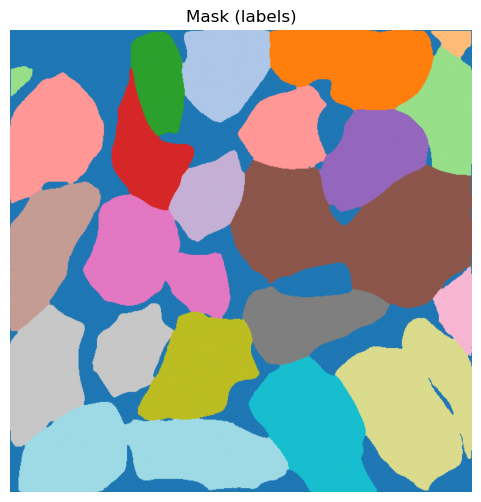

In [8]:
from gradio_client import Client, handle_file
from perinuclear_analysis.analysis.segmentation_config import get_hf_token
import imageio.v3 as iio


# 0) Build/validate composite (if not already done)
def norm01(a):
    a = a.astype(np.float32); mn, mx = a.min(), a.max()
    return np.zeros_like(a) if mx <= mn else (a - mn) / (mx - mn)
ph_idx = channel_names.index("Phalloidin"); da_idx = channel_names.index("DAPI")
ph_mip = loaded_data[..., ph_idx].max(axis=0).astype(np.float32)
da_mip = loaded_data[..., da_idx].max(axis=0).astype(np.float32)
composite = 0.8*norm01(ph_mip) + 0.2*norm01(da_mip)
composite = np.clip(np.nan_to_num(composite, nan=0.0, posinf=1.0, neginf=0.0), 0, 1).astype(np.float32)

# 1) temp PNG
tmp_png = "/tmp/composite.png"
iio.imwrite(tmp_png, (composite*255).astype(np.uint8))

# 2) Authenticated client
token = get_hf_token()
client = Client("mouseland/cellpose", hf_token=token)

# 3) Two-step flow with pause + retry
def run_seg(resize):
    _ = client.predict(filepath=handle_file(tmp_png), api_name="/update_button") 
    time.sleep(1.0)
    return client.predict(
        filepath=[handle_file(tmp_png)],
        resize=resize, max_iter=250, flow_threshold=0.4, cellprob_threshold=0.0,
        api_name="/cellpose_segment",
    )

result = None
for rs in (600, 400):
    try:
        result = run_seg(rs)
        break
    except Exception as e:
        print(f"retry with smaller resize due to: {e}")
        time.sleep(1.0)

if result is None:
    raise RuntimeError("Cellpose Space failed after retries")

# 4) outputs and save to folder
masks_tif = result[2]["value"] if isinstance(result[2], dict) else (result[2].path if hasattr(result[2],"path") else result[2])
outlines_png = result[3]["value"] if isinstance(result[3], dict) else (result[3].path if hasattr(result[3],"path") else result[3])

mask = iio.imread(str(masks_tif)).astype(np.int32)
save_dir = Path("/fs/scratch/PAS2598/duarte63/outputs/cellpose"); save_dir.mkdir(parents=True, exist_ok=True)
dst_mask = save_dir / f"{image_path.stem}_phall_dapi_masks.tif"
dst_outl = save_dir / f"{image_path.stem}_phall_dapi_outlines.png"
Path(dst_mask).write_bytes(Path(masks_tif).read_bytes())
Path(dst_outl).write_bytes(Path(outlines_png).read_bytes())

plt.figure(figsize=(6,6))
plt.title("Mask (labels)")
plt.imshow(mask, cmap="tab20")
plt.axis("off")
plt.show()

INFO: Loading TIF mask: /fs/scratch/PAS2598/duarte63/outputs/cellpose/anti_ALIX_60_min_2.ome_phall_dapi_masks.tif
INFO: Mask contains 29 unique values
INFO: Successfully loaded mask with shape: (1800, 1800)
INFO: Loaded labeled mask with integer dtype: uint16
INFO: Estimated min_area threshold: fraction=0.3, median_area=95949 -> thr=28784
INFO: Starting compute_colocalization(ch_a=ALIX, ch_b=LAMP1, normalization_scope=mask, min_area=28784, max_border_fraction=0.01, border_margin_px=1, plot_mask=True)
INFO: Loading TIF mask: /fs/scratch/PAS2598/duarte63/outputs/cellpose/anti_ALIX_60_min_2.ome_phall_dapi_masks.tif
INFO: Mask contains 29 unique values
INFO: Successfully loaded mask with shape: (1800, 1800)
INFO: Loaded labeled mask with integer dtype: uint16
INFO: Image loaded: shape=(30, 1800, 1800, 4), channels=['LAMP1', 'Phalloidin', 'ALIX', 'DAPI'] | Mask loaded: shape=(1800, 1800), unique_labels=28
INFO: Filtering labels: min_area=28784, max_border_fraction=0.01, border_margin_px=1 -

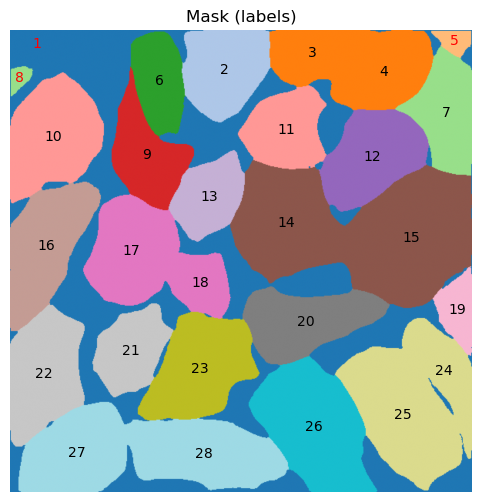

INFO: Displayed mask with label indices (kept=25, removed=3)
INFO: Normalization fitted (scope=mask) on 79061130 voxels per channel
INFO: Computed metrics for 25 labels; total_image n_voxels=79061130.0
INFO: compute_colocalization finished.


In [6]:
from perinuclear_analysis.analysis.colocalization import _load_mask, estimate_min_area_threshold
import pandas as pd


mask_path = Path("/fs/scratch/PAS2598/duarte63/outputs/cellpose/anti_ALIX_60_min_2.ome_phall_dapi_masks.tif")

min_area = estimate_min_area_threshold(mask_path, fraction_of_median=0.30)

res = compute_colocalization(
    image=results,  # dict[str, (array, meta)] or dict[str, array]
    mask=mask_path,
    channel_a="ALIX",
    channel_b="LAMP1",
    normalization_scope="mask",
    thresholding='costes',
    max_border_fraction=0.01,
    min_area=int(min_area),
    border_margin_px=1,
    plot_mask=True,
)

res["results"]["total_image"]

# Per-cell dataframe (one row per kept label)
df_cells = pd.DataFrame(res["results"]["per_label"]).sort_values("label")
# Optional: save
# df_cells.to_csv("per_cell_metrics.csv", index=False)

# Total-image (single row)
df_total = pd.DataFrame([res["results"]["total_image"]])

In [7]:
df_cells

,pearson_r,manders_m1,manders_m2,overlap_r,jaccard,n_voxels,thresholds,type,label
0,0.312481,0.476166,0.440625,0.407050,0.325531,2928960.0,"{'t_a': 0.0017914525233209133, 't_b': 0.003891...",cell2,2
1,0.407419,0.475049,0.439867,0.474033,0.323070,1894050.0,"{'t_a': 0.0016252321656793356, 't_b': 0.003443...",cell3,3
2,0.394546,0.506026,0.411272,0.455279,0.320748,2827980.0,"{'t_a': 0.002263419795781374, 't_b': 0.0039082...",cell4,4
3,0.351077,0.552913,0.371830,0.409085,0.320215,1971270.0,"{'t_a': 0.0029069827869534492, 't_b': 0.004222...",cell6,6
4,0.359313,0.506362,0.456769,0.435663,0.315093,2621700.0,"{'t_a': 0.0015547676011919975, 't_b': 0.003836...",cell7,7
5,0.406430,0.533833,0.383433,0.459660,0.324288,2524770.0,"{'t_a': 0.0029737544246017933, 't_b': 0.004277...",cell9,9
6,0.286944,0.481758,0.455124,0.369099,0.328663,3895560.0,"{'t_a': 0.0017333647701889277, 't_b': 0.004264...",cell10,10
7,0.410417,0.517040,0.415284,0.470011,0.324011,2447550.0,"{'t_a': 0.0020263255573809147, 't_b': 0.003690...",cell11,11
8,0.526109,0.564049,0.441693,0.561177,0.318871,3409830.0,"{'t_a': 0.002207101322710514, 't_b': 0.0037868...",cell12,12
9,0.453952,0.517724,0.519127,0.516067,0.327387,2048220.0,"{'t_a': 0.001652034348808229, 't_b': 0.0042520...",cell13,13
